# Day 3: Design of Experiments Hackathon

### 1. Imports

In [1]:
import os
import sys
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pickle
from typing import List, Dict, Tuple, Any, Union, Optional

# Add parent directories to the Python path.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

### 2. Load Training Data

In [2]:
with open("../training_data_day3.pickle", "rb") as file:
    training_data = pickle.load(file)
display(training_data)

[{'t': array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
          2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
          5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
          7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ]),
  'data': array([[9.87802958e-02, 1.36237829e+01, 0.00000000e+00, 1.42135286e+00],
         [1.08502428e-01, 1.15031150e+01, 1.32636708e-03, 1.49318539e+00],
         [1.04610507e-01, 1.08987164e+01, 2.65282069e-03, 1.37883409e+00],
         [1.13376683e-01, 1.14610348e+01, 4.06777290e-03, 1.30651411e+00],
         [1.20010264e-01, 1.31335078e+01, 6.19967016e-03, 1.09146389e+00],
         [1.21815911e-01, 1.29439405e+01, 6.96926817e-03, 1.14456463e+00],
         [1.27449885e-01, 1.22044819e+01, 9.00703124e-03, 1.21240180e+00],
         [1.30933351e-01, 1.12682800e+01, 1.02649000e-02, 9.93713314e-01],
         [1.35194565e-01, 1.14786077e+01, 1.25153066e-02, 1.00369552e+00],
         [1.65

### 3. Visualise Training Data

In [3]:
def plot_data(
    training_data: List[Dict[str, Any]],
) -> None:
    """
    Plot training data only.

    Parameters
    ----------
    training_data : List[Dict[str, Any]]
        List of dictionaries containing training data with keys:
        't', 'data', and 'initial_conditions'.
    """
    plt.figure(figsize=(15, 10))
    plt.suptitle("Training Data", fontsize=16)

    variables = ["Biomass", "Substrate", "Product", "Inhibitor"]
    colors_training = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#e377c2"]

    for idx, var in enumerate(variables):
        plt.subplot(2, 2, idx + 1)

        # Plot training data and predictions
        for i, exp in enumerate(training_data):
            color = colors_training[i]
            # Training data (circles)
            plt.scatter(
                exp["t"],
                exp["data"][:, idx],
                color=color,
                marker="o",
                alpha=0.6,
                label=f"Training Set {i + 1}",
            )

        plt.xlabel("Time")
        plt.ylabel(var)
        if idx == 0:  # Only show legend for first subplot
            plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()
    return

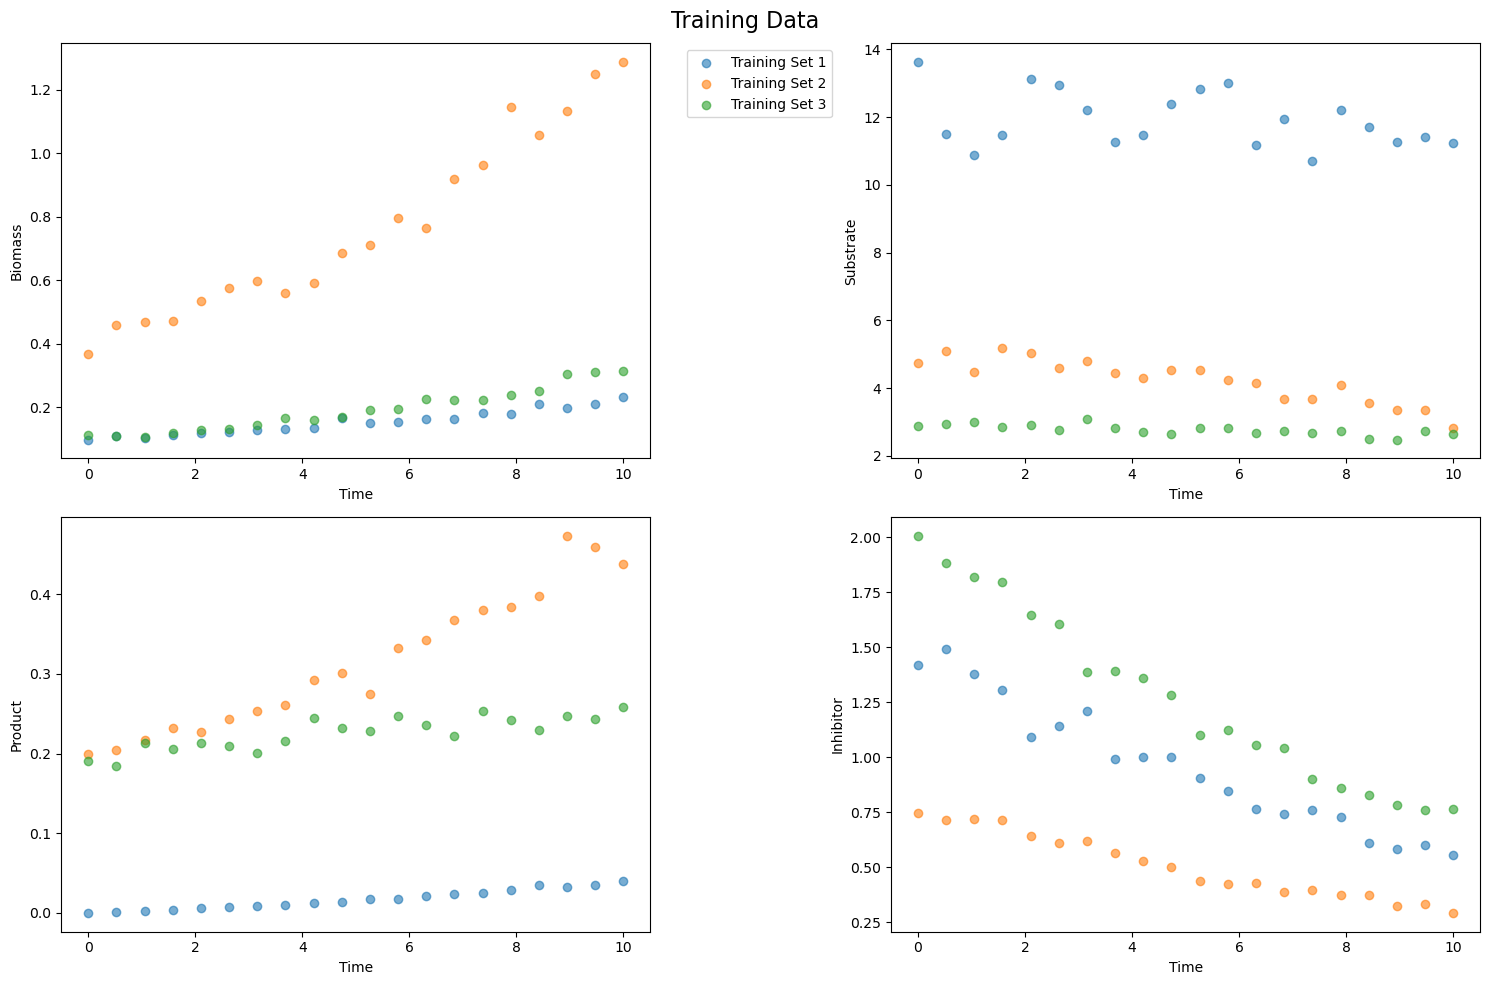

In [4]:
plot_data(training_data=training_data)

### 4. Hackathon!

Your task for this hackathon, building on the previous two days, is to develop an algorithm to estimate the model structure and parameter values that best fit the training data visualised above. 

This is similar to yesterday's challenge, however, you will also be given the opportunity to request two subsequent sets of experimental data from the same system. 

The idea is that you want to strategically decide which experiments to run to maximise the improvement in your model.

As with the previous days there are two tracks, with further details below. 

#### Helper Functions

To get started and help structure your approach, two functions are pre-coded for you:

- ```candidate_models ``` --> structures the leaf functions that could be used to make up your biomodel, and calculates the derivates.

- ```fitness__function``` --> basic routine that quantifies how good a given model is at describing the bio model (based on the training data).

In [5]:
def candidate_models(
    y: Union[List[float], np.ndarray],
    t: Union[float, np.ndarray],
    params: List[float],
    mask: List[int],
) -> List[float]:
    """
    Calculate derivatives based on selected growth mechanisms.

    Parameters
    ----------
    y : Union[List[float], np.ndarray]
        State variables [X, S, P, I] representing biomass, substrate,
        product, and inhibitor concentrations.
    t : Union[float, np.ndarray]
        Time point(s) at which to evaluate the model.
    params : List[float]
        Model parameters [mu_max, Ks, Ki, Yxs, Kp].
    mask : List[int]
        Binary mask indicating which growth terms to include.

    Returns
    -------
    List[float]
        Derivatives [dX/dt, dS/dt, dP/dt, dI/dt] at the given time point.
    """
    X, S, P, I = y
    mu_max, Ks, Kp, Yxs, Ki = params

    growth = mu_max * X
    # Growth terms
    # Monod Growth
    if mask[0]:
        growth *= S / (Ks + S)

    # Hill Kinetics Growth
    if mask[1]:
        n = 2
        growth *= S**n / (Ks**n + S**n)

    # Substrate Inhibition Factor
    if mask[2]:
        growth *= 1 / (1 + S / Ki)

    # Product Inhibition Factor (Competitive)
    if mask[3]:
        growth *= (Ks + S) / (S + Ks + (Ks * P / Kp)) # This term is modified so that is can be combined with mask 0 or 1 for a correct inhibition

    # Non-Competitive Product Inhibition
    if mask[4]:
        growth *= 1 / (1 + P / Kp)

    # Competitive Inhibition Factor
    if mask[5]:
        growth *= 1 / (1 + I / Ki)

    # Double Substrate Limited Factor (Inhibitor is a second substrate in case of an inhibitor)
    if mask[6]:
        growth *= I / (Ki + I)

    # Substrate Threshold Activation
    if mask[7]:
        S_threshold = 0.5
        growth *= (S - S_threshold) / (Ks + (S - S_threshold)) if S > S_threshold else 0

    # Inhibitor Saturation
    if mask[8]:
        growth *= 1 / (1 + (P / (P + Ki)))

    # Calculate derivatives
    dX = growth
    dS = -(growth / Yxs)
    dP = 0.3 * growth
    dI = -0.1 * I

    return [dX, dS, dP, dI]

In [6]:
def fitness_function(
    mask: List[int],
    params: List[float],
    training_data: List[Dict[str, Any]],
) -> Tuple[float, Optional[List[float]]]:
    """
    Calculate fitness of a solution.

    Parameters
    ----------
    mask : List[int]
        Binary mask indicating which growth terms to include.
    params : List[float]
        Model parameters [mu_max, Ks, Ki, Yxs, Kp].
    training_data : List[Dict[str, Any]]
        Training data to evaluate fitness against.

    Returns
    -------
    Tuple[float, Optional[List[float]]]
        Tuple containing:
        - Negative total error (including complexity penalty)
        - List of errors for each experiment (or None if error occurred)
    """
    total_error = 0
    n_active_terms = sum(mask)

    errors_by_experiment = []
    for experiment in training_data:
        t = experiment["t"]
        y_true = experiment["data"]
        y0 = experiment["initial_conditions"]

        try:
            y_pred = odeint(
                lambda y, t: candidate_models(y, t, params, mask),
                y0,
                t,
            )
            error = np.mean((y_true - y_pred) ** 2)
            total_error += error
            errors_by_experiment.append(error)
        except:
            return float("-inf"), None

    complexity_penalty = 0.05 * n_active_terms

    return -(total_error + complexity_penalty), errors_by_experiment

#### Submission & Additional Experimental Data

When you are ready to select your next experiments i.e., what initial conditions would you like an experiment run at, you can request us to generate it and send it to you.

As with the previous days, submission is via the live streamlit hackathon app, where you will need to submit the following:

- Your parameter mask i.e., a list of 1s and 0s indicating which leaves you are using in your model.
- The parameter values you are using in your model.

You may submit as many times as you like during the hackathon, but the assessment will take place at the end of the hackathon.